In [52]:
#Import Libraries

#pip install cpi
#pip install missingno
#pip install geopy
#pip install keras
#pip install tensorflow

import cpi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import missingno as msno
from geopy.geocoders import Nominatim

# FOR MODEL
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error



In [2]:
#Set Working Dir
path='C:/Users/tiward.FHMC.000/Desktop/Python Project'
os.chdir(path)
os.getcwd()

'C:\\Users\\tiward.FHMC.000\\Desktop\\Python Project'

In [3]:
# Create List of Source Files
Source_List=!cd Source Files & dir *tsr*.csv* /B # Must Run Outside Run File Command


In [4]:
#import Data
for file in Source_List:
        x='D'+file[0:4]
        print(x)
        path='Source Files/'+file
        print (path)
        exec("%s = pd.read_csv(path, dtype='str',low_memory=False)" % (x))
        if x =='D2003':
            Main=D2003                  
        else:
            exec("Main = Main.append(%s, ignore_index=True)"%(x))      
              

D2003
Source Files/2003_tsr_public_dataset.csv
D2004
Source Files/2004_tsr_public_dataset.csv
D2005
Source Files/2005_tsr_public_dataset.csv
D2006
Source Files/2006_tsr_public_dataset.csv
D2007
Source Files/2007_tsr_public_dataset.csv
D2008
Source Files/2008_tsr_public_dataset.csv
D2009
Source Files/2009_tsr_public_dataset.csv
D2010
Source Files/2010_tsr_public_dataset.csv
D2011
Source Files/2011_tsr_public_dataset.csv
D2012
Source Files/2012-tsr-public-dataset.csv


In [6]:
Main.describe()

,fy,rcdt,dst_name,dst_addr,dst_city,dst_st,dst_zip,dst_zip_plus4,sch_num,sch_name,...,assign3_desc,assignment_4,assign4_desc,assignment_5,assign5_desc,assignment_6,assign6_desc,assignment_7,assign7_desc,pct_admin
count,1624887,1624887,1624846,1624846,1624846,1624846,1624846,1624846,1624887,1624866,...,107427,1146853,44375,1146779,25630,1146779,8442,1146779,2490,1624842
unique,10,1266,1243,1171,697,3,718,1006,987,5785,...,199,137,136,122,121,106,105,91,90,74
top,2010,15016299025,City of Chicago SD 299,125 S Clark St,Chicago,IL,60603,5200,0001,City of Chicago SD 299,...,Basic and/or General Math,000,General Science,000,General Social Studies (Middle Grades Only),000,General Social Studies (Middle Grades Only),000,Reading,0
freq,167821,275836,275836,275836,276239,1624821,275836,275836,218572,20024,...,12191,1102478,6233,1121149,7434,1138337,1462,1144289,297,1513183


In [5]:
#Convert Variables to numeric as needed

Main_bckup=Main.copy()
Main=Main[Main.salary.astype('float') >0] # Remove Salary Equal to or Less Than 0
Main['salary']=Main.salary.astype('float')
Main['dst_zip']=Main.dst_zip.astype('float')
Main['sch_zip']=Main.sch_zip.astype('float')
Main['year'] = Main.fy.astype(int)

In [17]:
Main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616995 entries, 0 to 1624886
Data columns (total 62 columns):
fy                     1616995 non-null object
rcdt                   1616995 non-null object
dst_name               1616957 non-null object
dst_addr               1616957 non-null object
dst_city               1616957 non-null object
dst_st                 1616957 non-null object
dst_zip                1616957 non-null float64
dst_zip_plus4          1616957 non-null object
sch_num                1616995 non-null object
sch_name               1616977 non-null object
sch_addr               1499487 non-null object
sch_city               1499487 non-null object
sch_st                 1499487 non-null object
sch_zip                1499487 non-null object
sch_zip_plus4          1499487 non-null object
last_name              1616995 non-null object
first_name             1616995 non-null object
mid_init               1616995 non-null object
gender                 1616995 non-null 

In [36]:
#Install the CPI package to get current dollar values of salaries for comparisons over time.

cpi.update()
Main['salary_adjusted'] = Main.apply(lambda x: cpi.inflate(x.salary, x.year, to=2018), axis=1)

#Read in income by zip code level.

income_zip=pd.read_excel('Source Files/MedianZIP-3.xlsx')
income_zip['Dst_Zip']    = income_zip['Zip'].astype(float)
income_zip["Dst_Mean"]   = pd.to_numeric(income_zip.Mean, errors='coerce')
income_zip["Dst_Median"] = pd.to_numeric(income_zip.Median, errors='coerce')
income_zip['Sch_Zip']    = income_zip['Zip'].astype(float)
income_zip["Sch_Mean"]   = pd.to_numeric(income_zip.Mean, errors='coerce')
income_zip["Sch_Median"] = pd.to_numeric(income_zip.Median, errors='coerce')


#Merge Datasets 

Main1=pd.merge(income_zip[['Dst_Zip','Dst_Mean','Dst_Median']], Main, left_on='Dst_Zip', right_on='dst_zip', how='right')
Main_df=pd.merge(income_zip[['Sch_Zip','Sch_Mean','Sch_Median']], Main1, left_on='Sch_Zip', right_on='sch_zip', how='right')

Main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616995 entries, 0 to 1616994
Data columns (total 69 columns):
Sch_Zip                1497545 non-null float64
Sch_Mean               1497545 non-null float64
Sch_Median             1497545 non-null float64
Dst_Zip                1607089 non-null float64
Dst_Mean               1607089 non-null float64
Dst_Median             1607089 non-null float64
fy                     1616995 non-null object
rcdt                   1616995 non-null object
dst_name               1616957 non-null object
dst_addr               1616957 non-null object
dst_city               1616957 non-null object
dst_st                 1616957 non-null object
dst_zip                1616957 non-null float64
dst_zip_plus4          1616957 non-null object
sch_num                1616995 non-null object
sch_name               1616977 non-null object
sch_addr               1499487 non-null object
sch_city               1499487 non-null object
sch_st                 1499487 non

In [24]:
#Create Pivot View of 
pd.pivot_table(data=Main_df, index='dst_name', values=['Dst_Mean','Dst_Median','salary_adjusted'],aggfunc=[np.mean,np.median,len])
pd.pivot_table(data=Main_df, index='sch_name', values=['Sch_Mean','Sch_Median','salary_adjusted'],aggfunc=[np.mean,np.median,len])

mean                              \
                                      Sch_Mean  Sch_Median salary_adjusted   
sch_name                                                                     
123 & ABC Academy                          NaN         NaN    21184.878772   
21st Century Preparatory Center     56450.4051  50579.8932    66080.456799   
8 Points Charter School             55350.7836  45565.0720     1304.237469   
A B Shepard High Sch (Campus)       98600.4320  80235.3492    93459.705043   
A C Thompson Elem School            58523.9162  49016.8161    82849.060170   
A E R O  Spec Educ Coop                    NaN         NaN    69076.069059   
A E R O Educational Center          65875.0403  58618.2281    65036.200526   
A F Ames Elem School                92204.4325  70573.7023    68262.505686   
A J Katzenmaier Elem School         49458.1302  41598.8106    67585.878638   
A O Marshall Elem School            51831.0982  42979.7665    61621.215614   
A R Graiff Elem School              65732.0000  55457.0000    51210.624693   
A Vito Martinez Middle School       73489.5297  68397.2315    72224.215141   
A-C Central CUSD 262                       NaN         NaN   119713.612120   
A-C Central Elementary School       57194.4623  50174.7110    47520.522679   
A-C Central High School             58717.9770  51764.9603    49439.217846   
A-C Central Middle School           58717.9770  51764.9603    49623.492650   
ABC & 123 Academy                   69051.2272  55261.5023    31647.440576   
ABC Childrens Center                61752.9818  53318.1063    55184.641123   
ABC Toon Town Educational Center    98315.2406  89093.2923    26002.516487   
ALOP Alternative High School        44119.0609  35478.1413   102259.800647   
ARC                                 55350.7836  45565.0720    42519.612407   
Aasta - Orr High School             33397.3051  23004.0854    80023.240596   
Abbott Elem School                  44119.0609  35478.1413    76479.782096   
Abbott Middle School                66152.9221  58463.2921    81157.320339   
Abe Lincoln Elem School             52122.7542  44982.2351    65563.221875   
Abingdon CUSD 217                          NaN         NaN   112132.782855   
Abingdon High School                50963.9206  46321.6794    49816.171329   
Abingdon Middle School              50963.9206  46321.6794    48092.438376   
Able Program                        59418.7733  49951.4922    71648.985338   
Able Program - Garfield School      48965.2964  42272.9285    70744.709203   
...                                        ...         ...             ...   
York Comm High School              119415.1372  87215.7595    89110.834306   
Yorkville CUSD 115                         NaN         NaN   166873.716268   
Yorkville Grade School              92050.2273  84059.0216    55454.063033   
Yorkville High School               92050.2273  84059.0216    63382.284760   
Yorkville Intermediate School       92050.2273  84059.0216    54998.779848   
Yorkville Middle School             92050.2273  84059.0216    59175.018008   
Yorkwood CUSD 225                          NaN         NaN   124290.952437   
Yorkwood Elementary School          46702.1183  38632.9485    52829.307272   
Yorkwood High School                46702.1183  38632.9485    53528.280049   
Yorkwood Jr High School             46702.1183  38632.9485    62828.492026   
Young Adult Program                 78385.3753  65773.7353   129660.191072   
Young Elem School                   43087.0662  32715.9962    83951.938584   
Young Magnet High School           101252.6827  75222.2245    86092.750684   
Young Womens Leadership Chartr HS   63621.7306  47561.8415    60382.442398   
Youth Connections Charter HS        63621.7306  47561.8415    53673.234040   
Youth Farm School                   52402.5536  42479.2025    73626.989439   
Youth Farm in Peoria County         52402.5536  42479.2025    64487.767379   
Zadok Casey Middle School           53302.7024  38155.2588    62

In [ ]:
Main_df.columns

In [53]:
#Remove NANs 
Model_df =Main_df[['salary_adjusted','fy', 'gender', 'race_ethnicity_desc', 'location_desc', 'emply_desc',
       'months_employed', 'pct_emp', 'fte', 'dist_exp', 'state_exp',
       'out_of_state_exp', 'bacc_coll_desc', 'high_degre_desc',
       'adv_coll_desc', 'pos_desc']].dropna()

#Prepare Training Data

#### Variable That Were Dropped drop_list=['Sch_Zip', 'Sch_Mean', 'Sch_Median', 'Dst_Zip', 'Dst_Mean','Dst_Median', 'rcdt', 'dst_name', 'dst_addr', 'dst_city','dst_st', 'dst_zip', 'dst_zip_plus4', 'sch_num', 'sch_name', 'sch_addr',
####       'sch_city', 'sch_st', 'sch_zip', 'sch_zip_plus4', 'last_name',
####       'first_name', 'mid_init', 'race_ethnicity_cd',
####       'tsr_status_cd', 'tsr_status_desc',
####       'location_cd', 'emply_type', 'salary',        
####       'bacc_coll', 'high_degre_cd', 'adv_coll', 'pos_cd',
####       'low_grade', 'low_grd_desc', 'high_grade', 'high_grd_desc',
####       'assignment_1', 'assign1_desc', 'assignment_2', 'assign2_desc',
####       'assignment_3', 'assign3_desc', 'assignment_4', 'assign4_desc',
####       'assignment_5', 'assign5_desc', 'assignment_6', 'assign6_desc',
####       'assignment_7', 'assign7_desc', 'pct_admin', 'year',]

y = Model_df['salary_adjusted']
X = Model_df.drop(['salary_adjusted'], axis = 1)




# Split the dataset to trainand test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

#Setup Parameters
parameters = {'bootstrap': True,
              'min_samples_leaf': 1,
              'n_estimators': 100, 
              'min_samples_split': 2,
              'max_features': 'sqrt',
              'max_depth': 30,
              'max_leaf_nodes': None}

RF_model = RandomForestRegressor(**parameters)

#Preprocessing
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
tlist =['fy', 'gender', 'race_ethnicity_desc', 'location_desc', 'emply_desc', 'bacc_coll_desc', 'high_degre_desc', 'adv_coll_desc','pos_desc']

for item in tlist:
    print (item)
    train_X[item] = labelencoder.fit_transform(train_X[item])

for item in tlist:
    print(item)
    test_X[item] = labelencoder.fit_transform(test_X[item])
    
RF_model.fit(train_X, train_y)
RF_predictions = RF_model.predict(test_X)
score= RF_model.score(test_X, test_y)
#score = accuracy_score(test_y ,RF_predictions)
print(RF_model.feature_importances_)
print(score)


fy


C:\Users\tiward.FHMC.000\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gender
race_ethnicity_desc
location_desc
emply_desc
bacc_coll_desc
high_degre_desc
adv_coll_desc
pos_desc
fy


C:\Users\tiward.FHMC.000\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gender
race_ethnicity_desc
location_desc
emply_desc
bacc_coll_desc
high_degre_desc
adv_coll_desc
pos_desc


NameError: name 'X_test' is not defined

fy 0.0001
gender 0.02023
race_ethnicity_desc 0.00186
location_desc 0.00056
emply_desc 0.02704
months_employed 0.22898
pct_emp 0.05425
fte 0.05839
dist_exp 0.1809
state_exp 0.21588
out_of_state_exp 0.00525
bacc_coll_desc 0.001
high_degre_desc 0.03433
adv_coll_desc 0.00695
pos_desc 0.16428
Training R2 Score:  0.5728571249443617
Test  R2 Score:  0.5704792851089859
Training RSME Score:  19334.833380173204
Test  RSME Score:  19491.220170916375


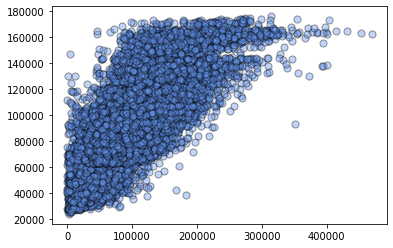

In [80]:
score= RF_model.score(test_X, test_y)
tr_score= RF_model.score(train_X, train_y)

RF_predictions_test = RF_model.predict(test_X)
RF_predictions_train = RF_model.predict(train_X)
rmse_test= np.sqrt(mean_squared_error(test_y ,RF_predictions_test))
rmse_train=np.sqrt(mean_squared_error(train_y ,RF_predictions_train))


for i, (x, y) in enumerate(zip(test_X.columns, np.round(RF_model.feature_importances_,5) )):
    print(x,str(y))

print('Training R2 Score: ', str(tr_score))
print('Test  R2 Score: ', str(score))
print('Training RSME Score: ', str(rmse_train))
print('Test  RSME Score: ', str(rmse_test))


plt.figure()
s = 50
a = 0.4
plt.scatter(test_y, RF_predictions, edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % RF_model.score(test_X, test_y))
  
#labelencoder.fit_transform(train_X['race_ethnicity_desc'])

#train_X.columns
#train_y.describe()

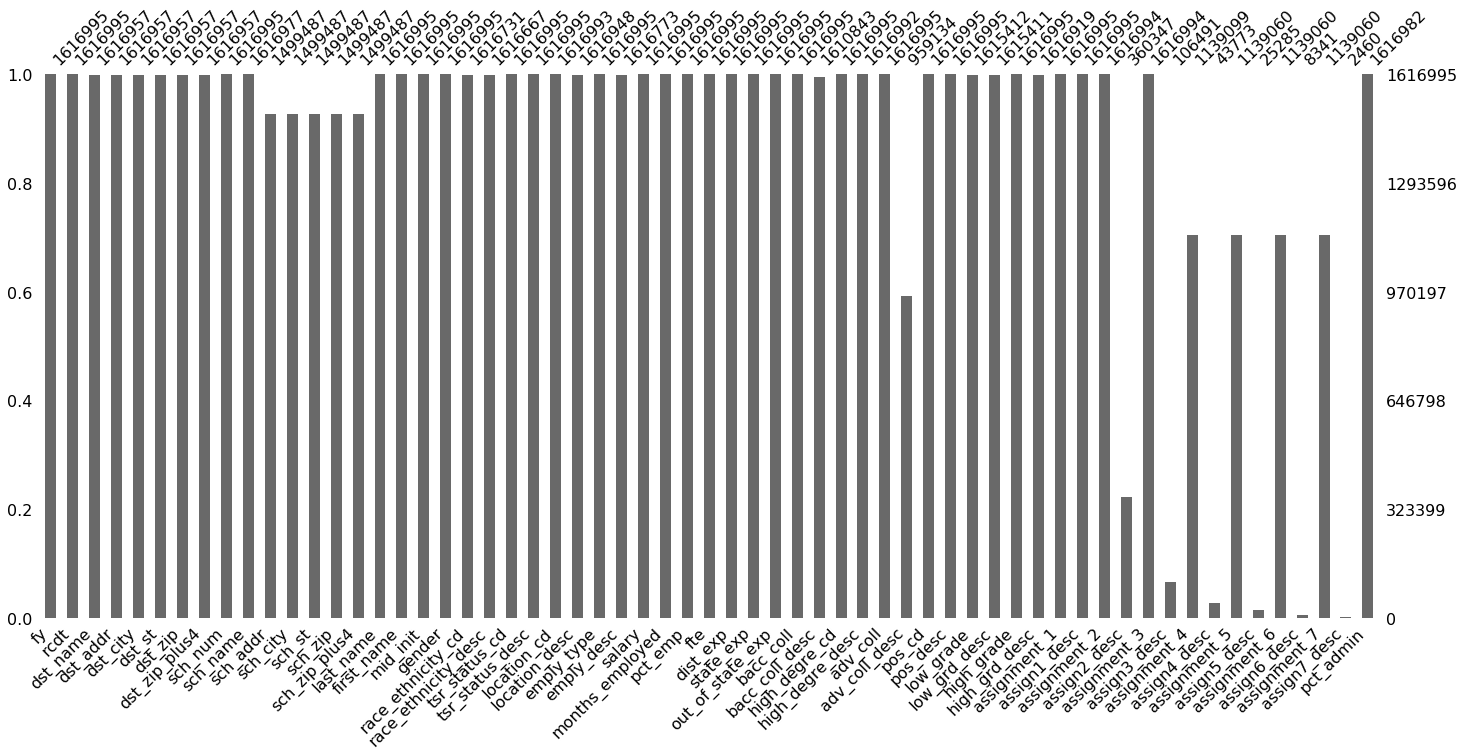

In [30]:
#Visualize Missing Data
#msno.heatmap(Main)
msno.bar(Main,labels=True)



In [16]:
#Setup Boxplot Function   
def boxplot_sorted(df, by, column,plot_type):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
  if plot_type == 'P':
      df3=df2[meds.index]
      df3.boxplot(figsize=(10,20),vert=False)
  else :
      df3=df2[meds.index]
      plt.xticks(rotation=45)
      sns.catplot(kind="box", data=df3, height=8.27,aspect=2,orient ='h')
      #sns.swarmplot(data=df3, size=2, color=".3", linewidth=0)




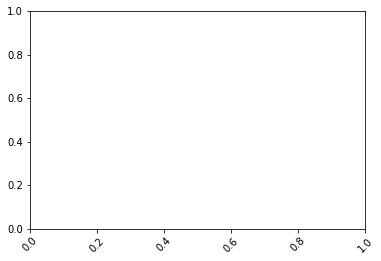

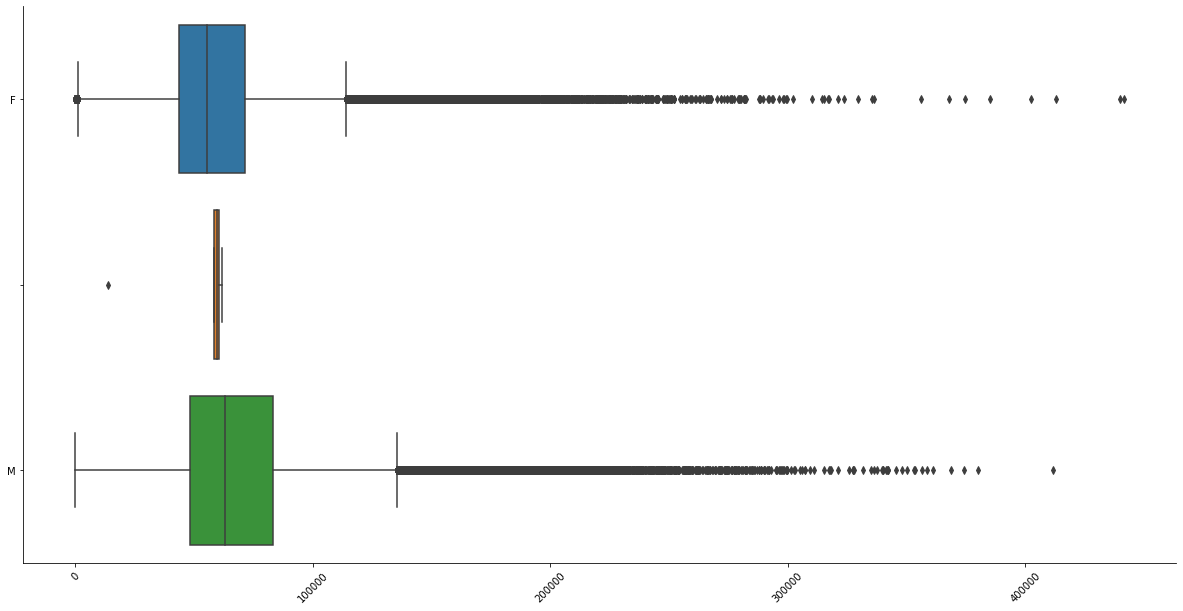

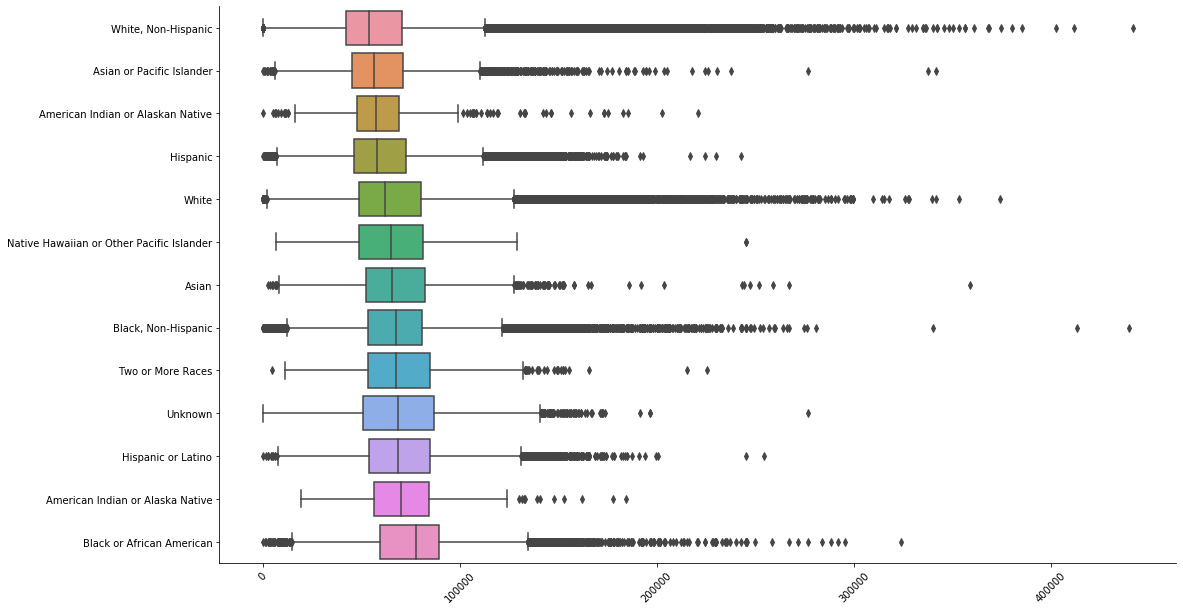

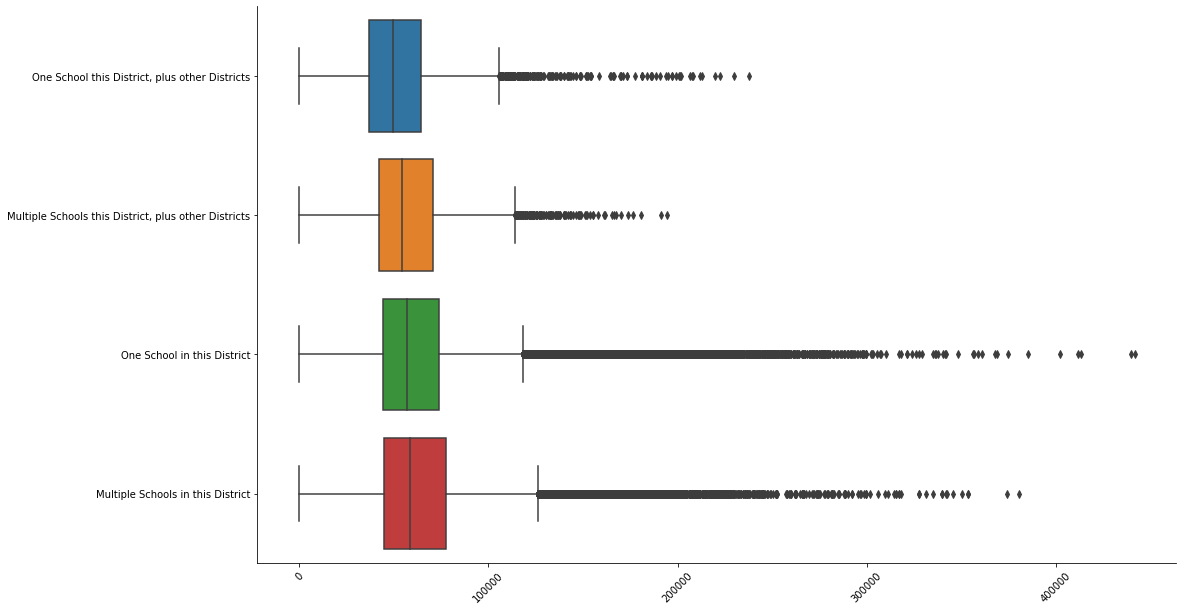

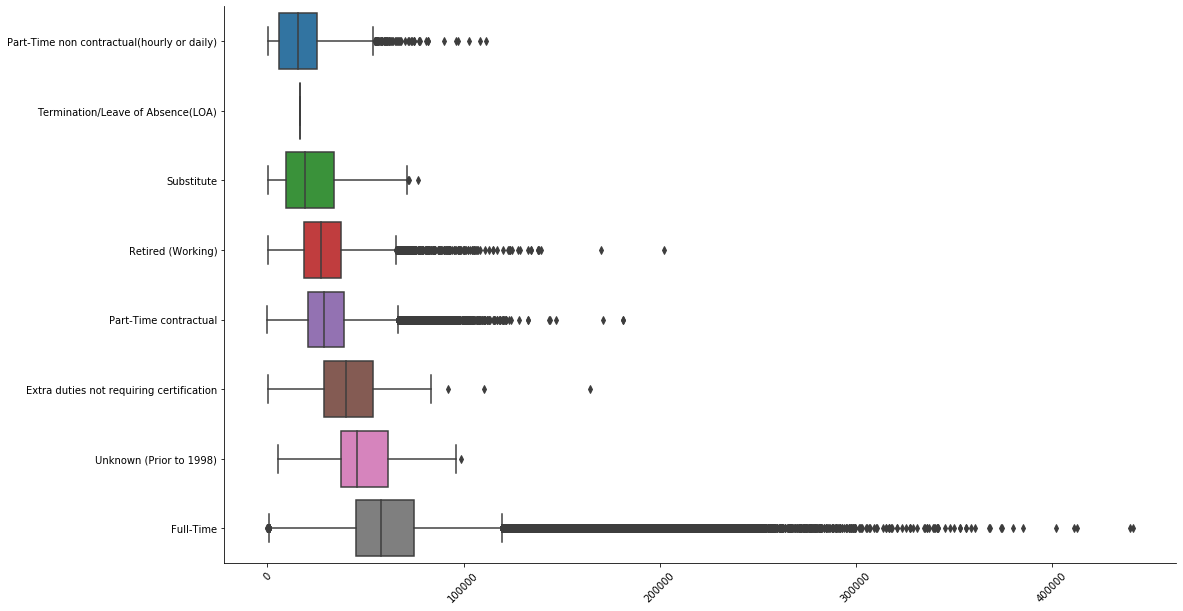

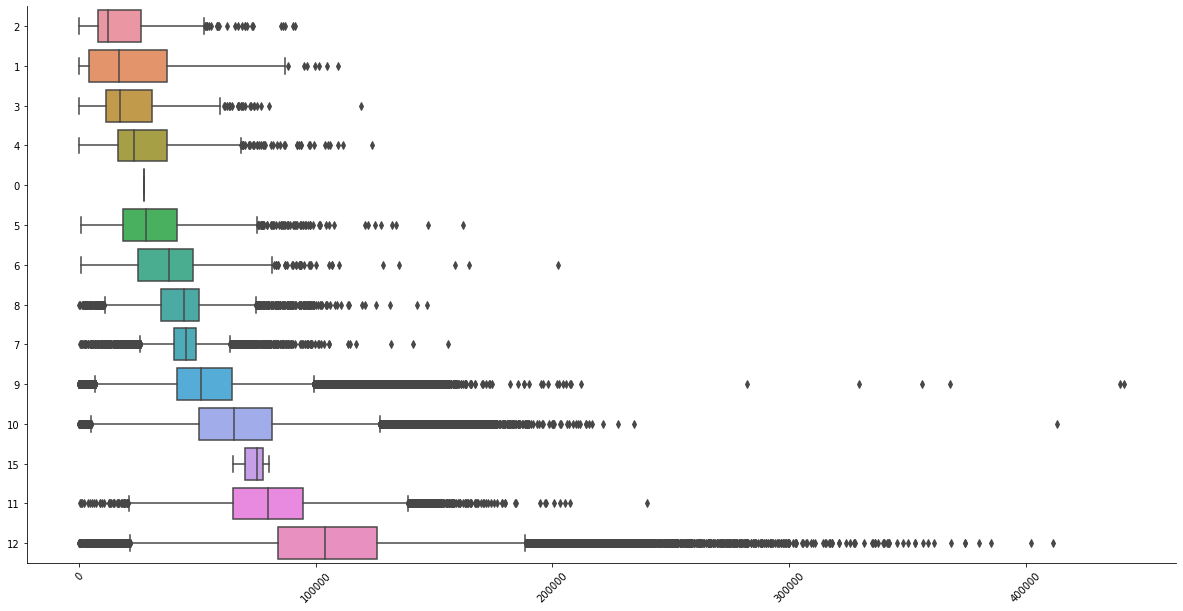

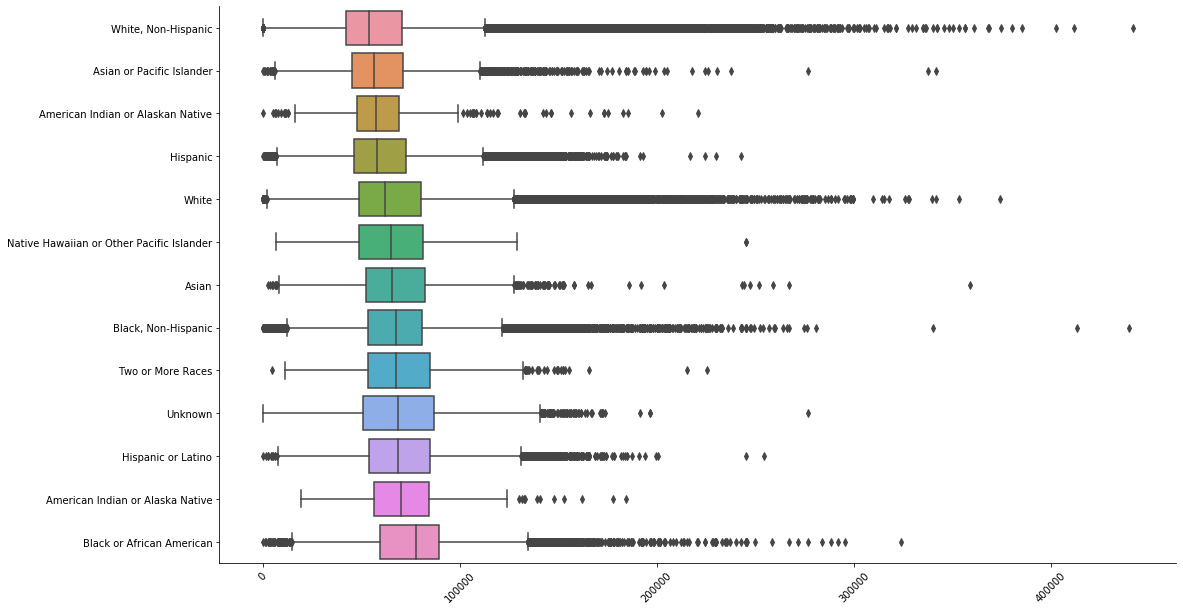

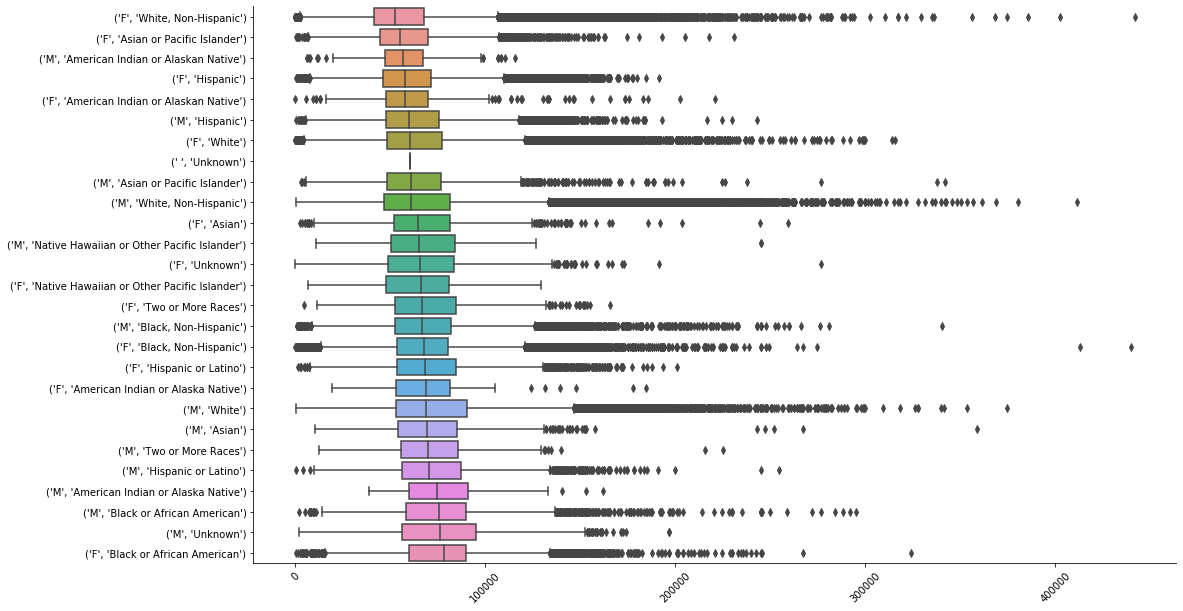

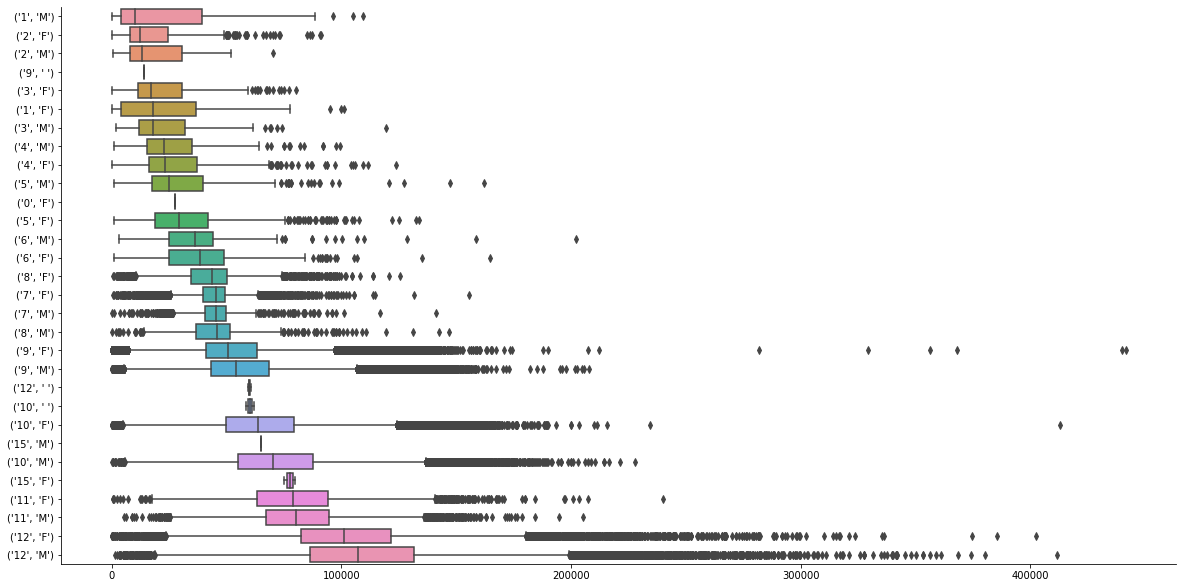

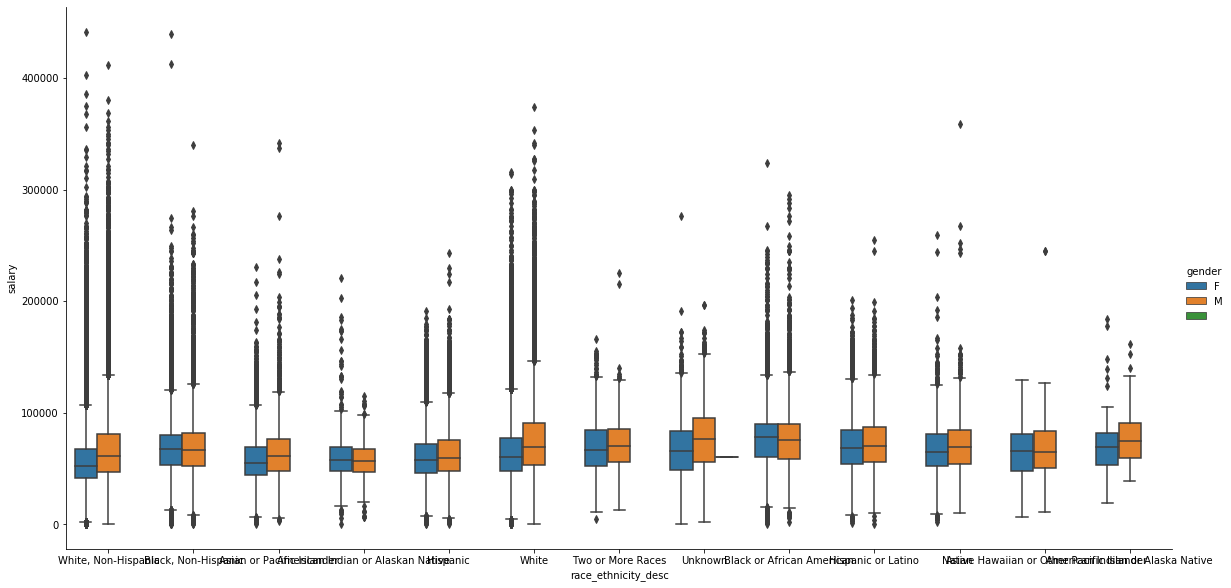

In [17]:
#Various Box Plots of Different Dimesion of Data
#Main.boxplot(column=['salary'],by=['gender'],figsize=(15,5),vert =False) #BoxPlot of Salary vs. Gender
#Main.boxplot(column=['salary'],by=['race_ethnicity_desc'],figsize=(20,15),rot=0,vert=False) #BoxPlot of Salary vs. Ethnicity
#Main.boxplot(column=['salary'],by=['location_desc'],figsize=(20,20),rot=0,vert =False) #BoxPlot of Salary vs. School Location
#Main.boxplot(column=['salary'],by=['emply_desc'],figsize=(20,20),rot=45) #BoxPlot of Salary vs. Gender
#Main.boxplot(column=['salary'],by=['months_employed'],figsize=(20,20),rot=45) #BoxPlot of Salary vs. Gender
#Main.boxplot(column=['salary'],by=['pos_desc'],figsize=(20,20),rot=0,vert=False) #BoxPlot of Salary vs. Gender
boxplot_sorted(Main,'gender','salary','s')
boxplot_sorted(Main,'race_ethnicity_desc','salary','s')
boxplot_sorted(Main,'location_desc','salary','s')
boxplot_sorted(Main,'emply_desc','salary','s')
boxplot_sorted(Main,'months_employed','salary','s')
boxplot_sorted(Main,['gender','race_ethnicity_desc'],'salary','s')
boxplot_sorted(Main,['months_employed','gender'],'salary','s')
sns.catplot(x="race_ethnicity_desc", y="salary", hue='gender',kind="box", data=Main,height=8.27,aspect=2,orient='h')


City of Chicago SD 299               20007
Other Location                       12826
Lincoln Elem School                   9596
Washington Elem School                6318
Jefferson Elem School                 4186
Central Elem School                   3705
Lincoln Middle School                 3263
Adlai E Stevenson High School         3260
Neuqua Valley High School             2927
Evanston Twp High School              2869
Lyons Twp High Sch                    2841
New Trier Township H S Winnetka       2829
Warren Township High School           2647
Waukegan High School                  2617
Waubonsie Valley High School          2585
Rockford SD 205                       2560
Lane Technical High School            2530
Sangamon Area Spec Ed Dist            2520
Carl Sandburg High School             2462
Comm H S Dist 99 - South High Sch     2387
Central High School                   2359
Lincoln Elementary School             2346
Macon-Piatt Spec Educ Jnt Agr         2320
Oak Park & 

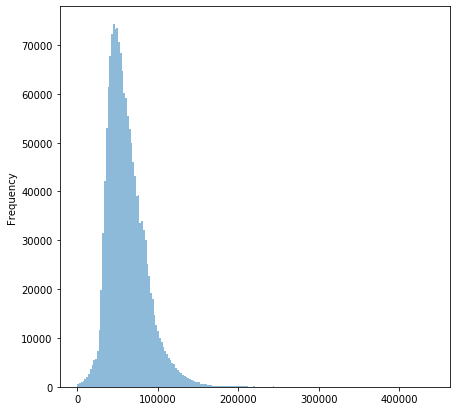

In [28]:
#Histogram of of Salary
Main['salary'].plot.hist(alpha=0.5, bins=200 ,figsize =(7,7))
#Plot of Counts
Main['sch_name'].value_counts() 
#.plot(kind='bar',figsize=(7,10))